## Mud card answers
- **why we change the confusion matrix to get condition negative and condition positive to have 90% of accuracy?**
    - the confusion matrix didn't change, we just normalize it differently
- **We are going to learn AB testing next class?**
    - we will cover a bit of that after the thanksgiving break
    - AB testing is also known as hypothesis testing and you'll cover more of that in data2020
- **Actually I can't find the sample_weight in XGbosst. Also I plug it in params and the RMSE does not change. I find a similar name that "sample_type: weighted. " Is that the class weight in xgb?**
    - search for 'sample_weight' in the python api [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html)
    - I'm not sure what values you tried with sample_weight but RMSE is a regression metric, sample weight is most useful in imbalanced classification
- **Can you please explain one more time how it works when all features in test set are all missing?**
    - I recommend you read through the two papers I linked
    - you can still train models if you have other features that are complete
    - e.g., in the kaggle house price dataset, three features contain missing values and 218 features are complete
    - even if all three features are missing, you can still use the other 218 features
- **a bit confused on when to apply reduced features vs XGB**
    - when you work with missing data, you'll likely want to try both
- **For the accuracy example you showed in class, the deployed model had an accuracy below the baseline. Is this always the case? I have nothing other than intuition telling me that it should be at least at baseline some of the time, but I don't necessarily see how.**
    - accuracy can be under the baseline but such models are not useful

## Global feature importance metrics
By the end of this module, you will be able to
 - perform permutation feature importance calculation
 - study the coefficients of linear models
 - outlook to other metrics 

## The supervised ML pipeline
The goal: Use the training data (X and y) to develop a <font color='red'>model</font> which can <font color='red'>accurately</font> predict the target variable (y_new') for previously unseen data (X_new).

**1. Exploratory Data Analysis (EDA)**: you need to understand your data and verify that it doesn't contain errors
   - do as much EDA as you can!
    
**2. Split the data into different sets**: most often the sets are train, validation, and test (or holdout)
   - practitioners often make errors in this step!
   - you can split the data randomly, based on groups, based on time, or any other non-standard way if necessary to answer your ML question

**3. Preprocess the data**: ML models only work if X and Y are numbers! Some ML models additionally require each feature to have 0 mean and 1 standard deviation (standardized features)
   - often the original features you get contain strings (for example a gender feature would contain 'male', 'female', 'non-binary', 'unknown') which needs to transformed into numbers
   - often the features are not standardized (e.g., age is between 0 and 100) but it needs to be standardized
    
**4. Choose an evaluation metric**: depends on the priorities of the stakeholders
   - often requires quite a bit of thinking and ethical considerations
     
**5. Choose one or more ML techniques**: it is highly recommended that you try multiple models
   - start with simple models like linear or logistic regression
   - try also more complex models like nearest neighbors, support vector machines, random forest, etc.
    
**6. Tune the hyperparameters of your ML models (aka cross-validation)**
   - ML techniques have hyperparameters that you need to optimize to achieve best performance
   - for each ML model, decide which parameters to tune and what values to try
   - loop through each parameter combination
       - train one model for each parameter combination
       - evaluate how well the model performs on the validation set
   - take the parameter combo that gives the best validation score
   - evaluate that model on the test set to report how well the model is expected to perform on previously unseen data
    
<span style="background-color: #FFFF00"> **7. Interpret your model**: black boxes are often not useful</span>
   - check if your model uses features that make sense (excellent tool for debugging)
   - often model predictions are not enough, you need to be able to explain how the model arrived to a particular prediction (e.g., in health care)

## Motivation
 - debugging ML models is tough
    - a model that runs without errors/warning is not necessarily correct
 - how do you know that you model is correct?
    - check test set predictions
       - in regression: check points with a large difference between true and predicted values
       - in classification: confusion matrix, check out FPs and FNs
    - inspect your model
       - especially useful for non-linear models
       - metrics to measure how much a model depends on a feature is one way to inspect your model

## <font color='LIGHTGRAY'>Global feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
 - **perform permutation feature importance calculation**
 - <font color='LIGHTGRAY'>study coefficients of linear models</font>
 - <font color='LIGHTGRAY'>outlook to other metrics </font>

## Permutation feature importance
 - model agnostic, you can use it with any supervised ML model
 - steps:
    - train a model and calculate a test score :)
    - randomly shuffle a single feature in the test set
    - recalculate the test score with the shuffled data
    - model score worsens because the shuffling breaks the relationship between feature and target
    - the larger the difference, the more important the feature is

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt

df = pd.read_csv('data/adult_data.csv')
label = 'gross-income'
y = LabelEncoder().fit_transform(df[label])
df.drop(columns=[label],inplace=True)
X = df
ftr_names = X.columns
print(X.head())
print(y)

   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0          2174             0              40   United-States  
1           

In [2]:
def ML_pipeline_kfold(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,SVC())
    # the parameter(s) we want to tune
    param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100],
                  'svc__gamma': [0.01, 0.1, 1, 10, 100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1,verbose=10)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, X_test, y_test

## Be careful, SVM is used on a relatively large dataset

In [3]:
grid, X_test, y_test = ML_pipeline_kfold(X,y,42,4)
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

# save the output so I can use it later
import pickle
file = open('results/grid.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV 2/4; 2/25] START svc__C=0.01, svc__gamma=0.1................................
[CV 2/4; 2/25] END svc__C=0.01, svc__gamma=0.1;, score=(train=0.822, test=0.814) total time= 1.5min
[CV 1/4; 4/25] START svc__C=0.01, svc__gamma=10.................................
[CV 1/4; 4/25] END svc__C=0.01, svc__gamma=10;, score=(train=0.759, test=0.759) total time= 4.4min
[CV 3/4; 6/25] START svc__C=0.1, svc__gamma=0.01................................
[CV 3/4; 6/25] END svc__C=0.1, svc__gamma=0.01;, score=(train=0.843, test=0.844) total time= 1.2min
[CV 3/4; 7/25] START svc__C=0.1, svc__gamma=0.1.................................
[CV 3/4; 7/25] END svc__C=0.1, svc__gamma=0.1;, score=(train=0.852, test=0.853) total time=  58.2s
[CV 3/4; 8/25] START svc__C=0.1, svc__gamma=1...................................
[CV 3/4; 8/25] END svc__C=0.1, svc__gamma=1;, score=(train=0.779, test=0.772) total time= 4.4min
[CV 1/4; 10/25] START svc__C=0.1, svc_

0.8624289881774911
{'svc__C': 1, 'svc__gamma': 0.1}


In [5]:
import pickle
file = open('results/grid.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

np.random.seed(42)

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.8624289881774911
test baseline =  0.7587901120835252
shuffling age
   shuffled test score: 0.851 +/- 0.002
shuffling workclass
   shuffled test score: 0.861 +/- 0.001
shuffling fnlwgt
   shuffled test score: 0.862 +/- 0.001
shuffling education
   shuffled test score: 0.86 +/- 0.001
shuffling education-num
   shuffled test score: 0.839 +/- 0.002
shuffling marital-status
   shuffled test score: 0.842 +/- 0.002
shuffling occupation
   shuffled test score: 0.844 +/- 0.002
shuffling relationship
   shuffled test score: 0.851 +/- 0.003
shuffling race
   shuffled test score: 0.862 +/- 0.0
shuffling sex
   shuffled test score: 0.862 +/- 0.0
shuffling capital-gain
   shuffled test score: 0.823 +/- 0.001
shuffling capital-loss
   shuffled test score: 0.855 +/- 0.001
shuffling hours-per-week
   shuffled test score: 0.855 +/- 0.002
shuffling native-country
   shuffled test score: 0.862 +/- 0.001


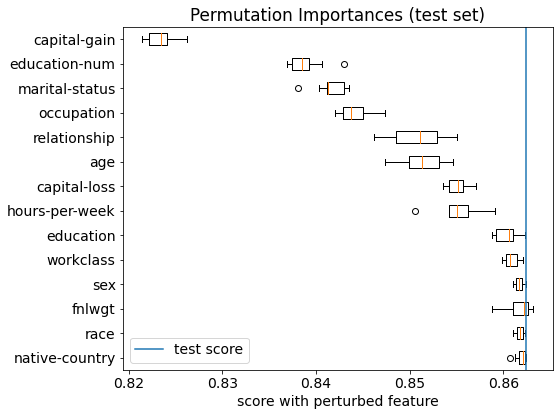

In [6]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

## Check out sklearn's permutation importance!

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

## Cons of permutation feature importance
- strongly correlated features
   - if one of the features is shuffled, the model can still use the other correlated feature
   - both features appear to be less important but they might actually be important
   - solution:
      - check the correlation matrix plot
      - remove all but one of the strongly correlated features
- no feature interactions
   - one feature might appear unimportant but combined with another feature could be important
   - solution:
      - permute two features to measure how important feature pairs are
      - this can be computationally expensive

## Quiz

## <font color='LIGHTGRAY'>Global feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
 - <font color='LIGHTGRAY'>perform permutation feature importance calculation</font>
 - **study the coefficients of linear models**
 - <font color='LIGHTGRAY'>outlook to other metrics </font>

## Coefficients of linear models
- the coefficients of linear and logistic regression can be used as a measure of feature importance **ONLY IF** all features have a zero mean and the same standard deviation (usually 1)
   - all features meaning that the one-hot encoded and ordinal features as well!
- then the absolute value of the coefficients can be used to rank them

## Let's rewrite the kfold CV function a bit

In [11]:
from sklearn.linear_model import LogisticRegression
def ML_pipeline_kfold_LR1(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,LogisticRegression(penalty='l2',solver='lbfgs',max_iter=10000000))
    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10,100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

test score: 0.8582834331337326


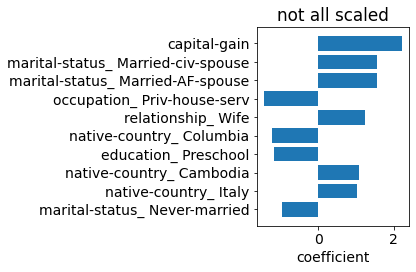

In [12]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold_LR1(X,y,42,4)
print('test score:',grid.score(X_test,y_test))
coefs = grid.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('not all scaled')
plt.tight_layout()
plt.savefig('figures/LR_coefs_notscaled.png',dpi=300)
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
def ML_pipeline_kfold_LR2(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    final_scaler = StandardScaler()
    pipe = make_pipeline(preprocessor,final_scaler,LogisticRegression(penalty='l2',solver='lbfgs'))
    # the parameter(s) we want to tune
    param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10,100]}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=-1)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = cont_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

test score: 0.857976354982343


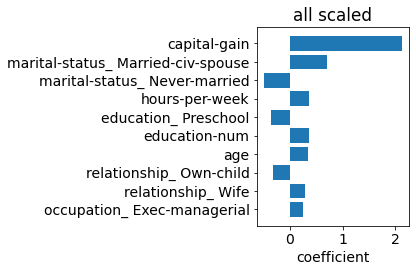

In [14]:
grid, feature_names, X_test, y_test = ML_pipeline_kfold_LR2(X,y,42,4)
print('test score:',grid.score(X_test,y_test))
coefs = grid.best_estimator_[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('all scaled')
plt.tight_layout()
plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
plt.show()

<table><tr>
<td> <img src="figures/LR_coefs_notscaled.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="figures/LR_coefs_scaled.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

## <font color='LIGHTGRAY'>Global feature importance metrics</font>
<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
 - <font color='LIGHTGRAY'>perform permutation feature importance calculation</font>
 - <font color='LIGHTGRAY'>study the coefficients of linear models</font>
 - **outlook to other metrics**


- SVM:
   - SVC.coef_ and SVR.coef_ can be used as a metric of feature importance if **all** features are standardized
   - for linear SVMs only!
- random forest:
   - RandomForestRegressor.feature_importances_ and RandomForestClassification.feature_importances_
   - gini importance or mean decrease impurity, see [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) and [here](https://stackoverflow.com/questions/15810339/how-are-feature-importances-in-randomforestclassifier-determined)
- XGBoost:
   - five different metrics are implemented, see [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score) and [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

## Quiz

## Mudcard